In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import h5py
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
import pywt
from plotly import tools
from plotly.offline import init_notebook_mode, iplot, plot
# import cufflinks as cf
import plotly.graph_objs as go
from datetime import datetime
from datetime import timedelta
import warnings
import time
warnings.filterwarnings('ignore')

In [2]:
X_train = h5py.File("original_data/X_train.h5", "r")
y_train_ = pd.read_csv("original_data/y_train.csv").as_matrix()[:, 1].squeeze()
df_train = pd.DataFrame(data=X_train["features"][:])

In [3]:
def label_columns(df):
    l_columns = ['num_pso', 
             'mean_amp_pso',
             'mean_dur_pso',
              'amp_cso',
              'dur_cso',
              'curr_sleep_stage',
              'time_since_sleep',
              'time_in_ds',
              'time_in_ls',
              'time_in_rs',
              'time_in_ws']
    for i in range(12, 1261+1):
        l_columns.append('eeg_signal_%s'%(i-12+1))
    df.columns = l_columns

    return df
df_train=label_columns(df_train)

In [4]:
eegcolumns = ['eeg_signal_%s'%(i-12+1) for i in range(12, 1261+1)]
cols=list(df_train.columns)
selected_var=[c for c in eegcolumns]

X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(df_train[selected_var], y_train_, test_size=0.10,random_state=0, stratify=y_train_)

In [5]:
int(len(X_train_cnn)/2)

117735

In [18]:
n_image_train=16000

scales = range(1, 41)

start = time.time()

Array_images_train = np.ndarray(shape=(n_image_train, 40, 1250))

for i in range(0,n_image_train):
    Array_images_train[i, :, :] = (abs(pywt.cwt(X_train_cnn.iloc[i,:], scales,"morl", 1/125)[0]))**2

end = time.time()

print("Runtime for %d images (seconds): %.2f" % (n_image_train, (end - start)))

Runtime for 16000 images (seconds): 231.79


#### Run Time

Local setup: 234 seconds

AWS instance: x seconds

In [19]:
n_image_test=16000

scales = range(1,41)

start = time.time()

Array_images_test=np.ndarray(shape=(n_image_test, 40, 1250))

for i in range(0,n_image_test):
    Array_images_test[i, :, :] = (abs(pywt.cwt(X_val_cnn.iloc[i,:], scales,"morl", 1/125)[0]))**2

end = time.time()

print("Runtime for %d images (seconds): %.2f" % (n_image_test, (end - start)))

Runtime for 16000 images (seconds): 231.17


In [20]:
x_train = Array_images_train
y_train_cnn_cut = y_train_cnn[0:n_image_train]
x_test = Array_images_test
y_test_cnn_cut = y_val_cnn[0:n_image_test]

## Autoencoding images 

In [9]:
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Declaration of Hidden Layers and Variables

In [21]:
# this is the size of our encoded representations
encoding_dim = 32 # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
 
# this is our input placeholder
input_img = Input(shape=(50000,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(50000, activation='sigmoid')(encoded)
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
# configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy') #values normalized between 0 and 1

### Visualising Images

In [22]:
Array_images_train[6].shape

(40, 1250)

<Figure size 7200x7200 with 0 Axes>

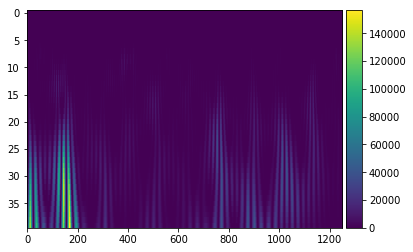

<Figure size 7200x7200 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

plt.figure()
ax = plt.gca()

im = ax.imshow(Array_images_train[100,:,:], aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.figure(figsize=(100,100))

### Preparing the input data 

In [30]:
(x_train_mnist, _), (x_test_mnist, _) = mnist.load_data()
# normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.
x_train_mnist = x_train_mnist.astype('float32') / 255.
x_test_mnist = x_test_mnist.astype('float32') / 255.
x_train_mnist = x_train_mnist.reshape((len(x_train_mnist), np.prod(x_train_mnist.shape[1:])))
x_test_mnist = x_test_mnist.reshape((len(x_test_mnist), np.prod(x_test_mnist.shape[1:])))
print(x_train_mnist.shape)
print(x_test_mnist.shape)

(60000, 784)
(10000, 784)


In [31]:
x_train_mnist

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [32]:
# normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(16000, 50000)
(16000, 50000)


### Training Autoencoders for 50 epochs

In [ ]:
autoencoder.fit(x_train, x_train,
epochs=50,
batch_size=256,
shuffle=True,
validation_data=(x_test, x_test))
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


Train on 16000 samples, validate on 16000 samples
Epoch 1/50
16000/16000 [==============================] - 20s 1ms/step - loss: -68.2029 - val_loss: -71.1820
Epoch 2/50
16000/16000 [==============================] - 16s 986us/step - loss: -70.8440 - val_loss: -71.2973
Epoch 3/50
16000/16000 [==============================] - 16s 986us/step - loss: -70.9612 - val_loss: -71.4138
Epoch 4/50
16000/16000 [==============================] - 16s 998us/step - loss: -71.0042 - val_loss: -71.4325
Epoch 5/50
16000/16000 [==============================] - 16s 983us/step - loss: -71.0151 - val_loss: -71.4285
Epoch 6/50
16000/16000 [==============================] - 16s 994us/step - loss: -71.0308 - val_loss: -71.4629
Epoch 7/50
16000/16000 [==============================] - 16s 994us/step - loss: -71.0405 - val_loss: -71.4978
Epoch 8/50
16000/16000 [==============================] - 16s 991us/step - loss: -71.0443 - val_loss: -71.4690
Epoch 9/50
16000/16000 [==============================] - 16s 9

### Visualising

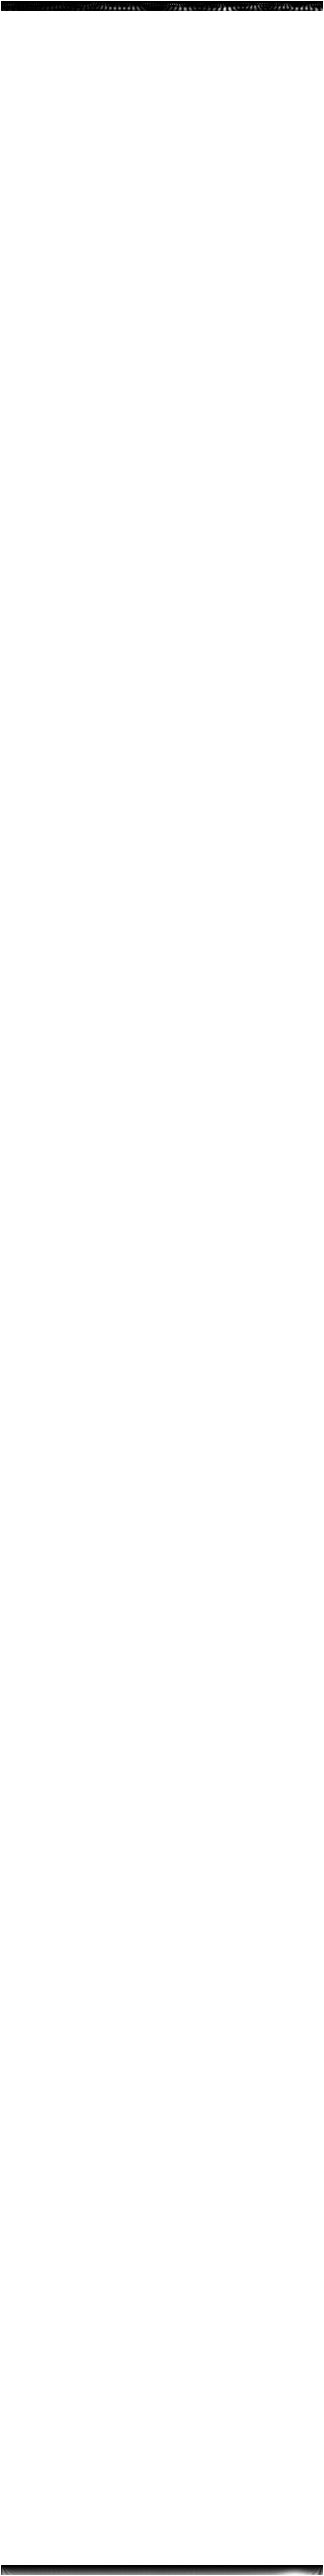

In [68]:
n = 1 # how many digits we will display
# plt.figure(figsize=(100, 100))
#for i in range(n):
# display original
# ax = plt.subplot(2, n, i + 1)
# plt.imshow(x_test[i].reshape(40, 1250))
# plt.gray()
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)

ax = plt.gca()
im = ax.imshow(x_test[100,:,:], aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.figure(figsize=(100,100))


# display reconstruction
# ax = plt.subplot(2, n, i + 1 + n)
# plt.imshow(decoded_imgs[i].reshape(40, 1250))
# plt.gray()
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# plt.show()

ax = plt.gca()
im = ax.imshow(x_test[100,:,:], aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.figure(figsize=(100,100))

In [ ]:
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 
history = History()
 
img_x = 1250
img_y = 1250
img_z = 1
input_shape = (img_x, img_y, img_z)
 
num_classes = 3
batch_size = 16
epochs = 5
 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
    
y_train = keras.utils.to_categorical(y_train_cnn_cut, num_classes)
y_test = keras.utils.to_categorical(y_test_cnn_cut, num_classes)
 
 
model = Sequential()

model.add(Conv2D(4, kernel_size=(5, 5),activation='relu', input_shape=input_shape))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(num_classes, activation='softmax'))
 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])
 
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))